In [1]:
import os
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [43]:
def normalize_text(s):
    s = str(s)
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def load_dataset(path="data/emails.csv"):
    if os.path.exists(path):
        df = pd.read_csv(path)
        if "text" not in df.columns or "label" not in df.columns:
            raise ValueError("CSV must contain columns: text, label")
        df = df[["text", "label"]].dropna()
        df["text"] = df["text"].map(normalize_text)
        return df.reset_index(drop=True)
    demo = {
        "text": [
            "Congratulations you won a free gift card claim now",
            "Hey are we meeting at 5 today",
            "Limited offer earn money fast click link",
            "Please find attached the project report",
            "Winner selected call now to collect prize",
            "Let's have lunch tomorrow",
            "URGENT your account is suspended verify immediately",
            "Can you review my assignment tonight",
            "Exclusive deal buy now discount",
            "Mom asked you to call her"
        ],
        "label": ["spam","ham","spam","ham","spam","ham","spam","ham","spam","ham"]
    }
    df = pd.DataFrame(demo)
    df["text"] = df["text"].map(normalize_text)
    return df

df = load_dataset()
df.head()


,text,label
0,congratulations you won a free gift card claim...,spam
1,hey are we meeting at 5 today,ham
2,limited offer earn money fast click link,spam
3,please find attached the project report,ham
4,winner selected call now to collect prize,spam


In [3]:
df.shape, df["label"].value_counts()


((10, 2),
 label
 spam    5
 ham     5
 Name: count, dtype: int64)

In [4]:
eda = df.copy()
eda["char_len"] = eda["text"].str.len()
eda["word_count"] = eda["text"].str.split().map(len)

eda.describe(include="all")


,text,label,char_len,word_count
count,10,10,10.000000,10.000000
unique,10,2,NaN,NaN
top,congratulations you won a free gift card claim...,spam,NaN,NaN
freq,1,5,NaN,NaN
mean,NaN,NaN,36.700000,6.400000
std,NaN,NaN,9.322017,1.349897
min,NaN,NaN,25.000000,4.000000
25%,NaN,NaN,29.500000,6.000000
50%,NaN,NaN,37.500000,6.500000
75%,NaN,NaN,40.750000,7.000000


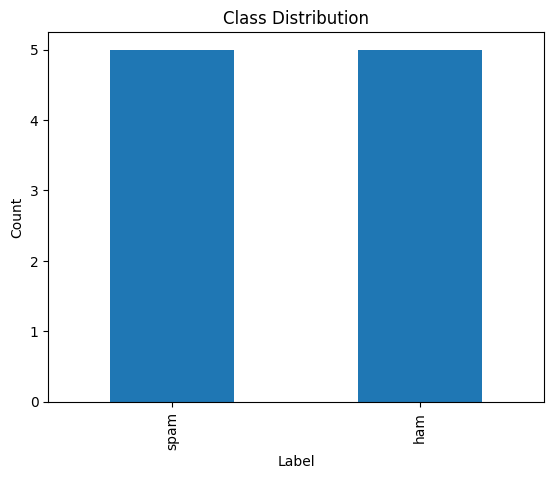

In [5]:
ax = eda["label"].value_counts().plot(kind="bar")
ax.set_title("Class Distribution")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
plt.show()


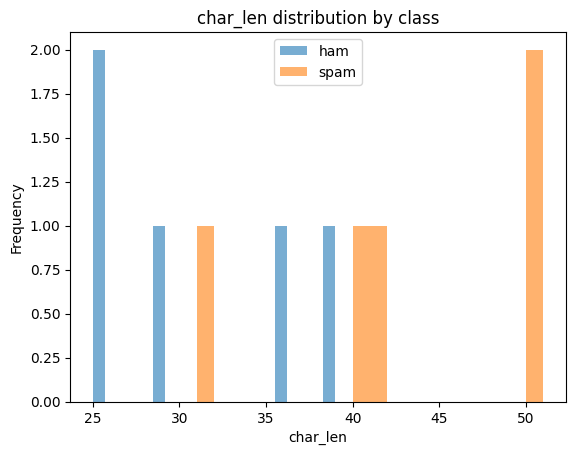

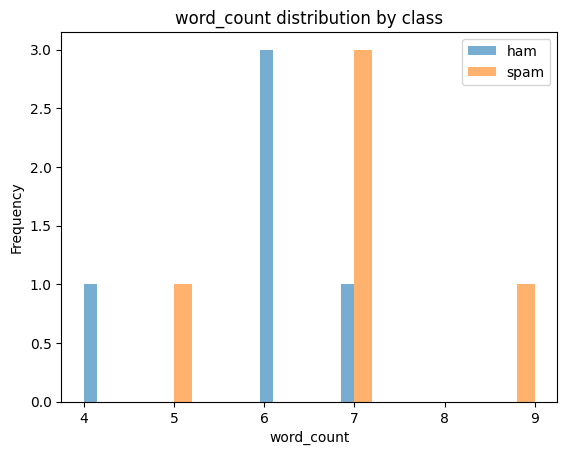

In [6]:
for col in ["char_len", "word_count"]:
    ax = eda.groupby("label")[col].plot(kind="hist", alpha=0.6, bins=20, legend=True)
    plt.title(f"{col} distribution by class")
    plt.xlabel(col)
    plt.show()


In [7]:
le = LabelEncoder()
y = le.fit_transform(df["label"])
X = df["text"].values

le.classes_, np.unique(y, return_counts=True)


(array(['ham', 'spam'], dtype=object), (array([0, 1]), array([5, 5])))

In [8]:
scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro"
}

def evaluate_cv(name, pipeline, X, y, cv):
    out = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    row = {
        "model": name,
        "cv_type": type(cv).__name__,
        "acc_mean": out["test_accuracy"].mean(),
        "acc_std": out["test_accuracy"].std(),
        "precision_macro_mean": out["test_precision_macro"].mean(),
        "recall_macro_mean": out["test_recall_macro"].mean(),
        "f1_macro_mean": out["test_f1_macro"].mean()
    }
    return row

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)

models = {
    "NaiveBayes": MultinomialNB(),
    "LogReg": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "LinearSVM": LinearSVC(random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE)
}

pipelines = {
    k: Pipeline([("tfidf", tfidf), ("model", v)])
    for k, v in models.items()
}

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [9]:
rows = []
for name, pipe in pipelines.items():
    rows.append(evaluate_cv(name, pipe, X, y, kfold))
    rows.append(evaluate_cv(name, pipe, X, y, skfold))

cv_results = pd.DataFrame(rows).sort_values(["cv_type", "f1_macro_mean"], ascending=[True, False])
cv_results


,model,cv_type,acc_mean,acc_std,precision_macro_mean,recall_macro_mean,f1_macro_mean
2,LogReg,KFold,0.8,0.244949,0.70,0.8,0.733333
0,NaiveBayes,KFold,0.7,0.244949,0.55,0.7,0.600000
4,LinearSVM,KFold,0.7,0.244949,0.55,0.7,0.600000
8,RandomForest,KFold,0.7,0.244949,0.55,0.7,0.600000
6,DecisionTree,KFold,0.5,0.316228,0.35,0.5,0.400000
9,RandomForest,StratifiedKFold,0.7,0.244949,0.55,0.7,0.600000
3,LogReg,StratifiedKFold,0.6,0.374166,0.50,0.6,0.533333
1,NaiveBayes,StratifiedKFold,0.5,0.316228,0.35,0.5,0.400000
5,LinearSVM,StratifiedKFold,0.5,0.316228,0.35,0.5,0.400000
7,DecisionTree,StratifiedKFold,0.5,0.316228,0.35,0.5,0.400000


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
len(X_train), len(X_test)


(8, 2)

In [14]:
rf_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_dist = {
    "model__n_estimators": [200, 400, 800],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
    "model__class_weight": [None, "balanced"]
}

min_class = np.min(np.bincount(y_train))
n_splits = int(min(5, min_class))

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search.fit(X_train, y_train)
search.best_params_, search.best_score_


({'model__n_estimators': 800,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 2,
  'model__max_features': None,
  'model__max_depth': 40,
  'model__class_weight': 'balanced'},
 np.float64(0.3333333333333333))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00         1
        spam       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



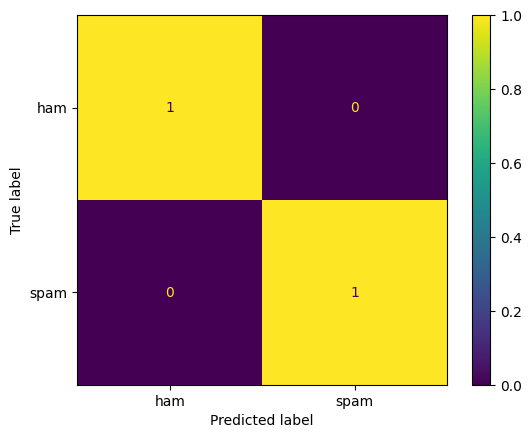

In [15]:
best_rf = search.best_estimator_
best_rf.fit(X_train, y_train)

pred = best_rf.predict(X_test)
print(classification_report(y_test, pred, target_names=le.classes_))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()


In [16]:
outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_scores = []

for train_idx, test_idx in outer.split(X, y):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    search.fit(X_tr, y_tr)
    best = search.best_estimator_
    best.fit(X_tr, y_tr)
    p = best.predict(X_te)
    _, _, f1, _ = precision_recall_fscore_support(y_te, p, average="macro", zero_division=0)
    outer_scores.append(f1)

np.mean(outer_scores), np.std(outer_scores), outer_scores


(np.float64(0.3333333333333333),
 np.float64(0.0),
 [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333])

In [20]:


min_class = int(np.min(np.bincount(y)))
n_splits = int(min(5, min_class))

skfold_safe = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
n_splits


5

In [24]:
skfold_stack = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

stack = StackingClassifier(
    estimators=[
        ("nb", Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)), ("m", MultinomialNB())])),
        ("svm", Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)), ("m", LinearSVC(random_state=RANDOM_STATE))]))
    ],
    final_estimator=LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    passthrough=False,
    cv=skfold_stack,
    n_jobs=-1
)

stack_scores = cross_validate(stack, X, y, cv=skfold_stack, scoring=scoring, n_jobs=-1)
{k: float(np.mean(v)) for k, v in stack_scores.items() if k.startswith("test_")}


{'test_accuracy': 0.38888888888888884,
 'test_precision_macro': 0.19444444444444442,
 'test_recall_macro': 0.5,
 'test_f1_macro': 0.27777777777777773}

In [26]:
X_test_dense = X_test_vec.toarray()

perm = permutation_importance(
    rf_model,
    X_test_dense,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="f1_macro"
)

importances = perm.importances_mean
idx = np.argsort(importances)[::-1][:20]
feature_names = np.array(vect.get_feature_names_out())

top = pd.DataFrame({"feature": feature_names[idx], "importance": importances[idx]})
top


,feature,importance
0,now,0.3
1,your account,0.0
2,you won,0.0
3,you to,0.0
4,you,0.0
5,won free,0.0
6,won,0.0
7,winner selected,0.0
8,winner,0.0
9,your,0.0


In [27]:
final_table = cv_results.copy()
final_table


,model,cv_type,acc_mean,acc_std,precision_macro_mean,recall_macro_mean,f1_macro_mean
2,LogReg,KFold,0.8,0.244949,0.70,0.8,0.733333
0,NaiveBayes,KFold,0.7,0.244949,0.55,0.7,0.600000
4,LinearSVM,KFold,0.7,0.244949,0.55,0.7,0.600000
8,RandomForest,KFold,0.7,0.244949,0.55,0.7,0.600000
6,DecisionTree,KFold,0.5,0.316228,0.35,0.5,0.400000
9,RandomForest,StratifiedKFold,0.7,0.244949,0.55,0.7,0.600000
3,LogReg,StratifiedKFold,0.6,0.374166,0.50,0.6,0.533333
1,NaiveBayes,StratifiedKFold,0.5,0.316228,0.35,0.5,0.400000
5,LinearSVM,StratifiedKFold,0.5,0.316228,0.35,0.5,0.400000
7,DecisionTree,StratifiedKFold,0.5,0.316228,0.35,0.5,0.400000


In [28]:
os.makedirs("results", exist_ok=True)
final_table.to_csv("results/model_comparison.csv", index=False)
final_table.head()


,model,cv_type,acc_mean,acc_std,precision_macro_mean,recall_macro_mean,f1_macro_mean
2,LogReg,KFold,0.8,0.244949,0.70,0.8,0.733333
0,NaiveBayes,KFold,0.7,0.244949,0.55,0.7,0.600000
4,LinearSVM,KFold,0.7,0.244949,0.55,0.7,0.600000
8,RandomForest,KFold,0.7,0.244949,0.55,0.7,0.600000
6,DecisionTree,KFold,0.5,0.316228,0.35,0.5,0.400000


In [29]:
import joblib
joblib.dump(best_rf, "results/best_model.joblib")
"saved"


'saved'

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [45]:
def add_text_features(df_in):
    df2 = df_in.copy()
    s = df2["text"].astype(str)
    df2["char_len"] = s.str.len()
    df2["word_count"] = s.str.split().map(len)
    df2["digit_count"] = s.str.count(r"\d")
    df2["punct_count"] = s.str.count(r"[^\w\s]")
    df2["exclam_count"] = s.str.count(r"!")
    df2["question_count"] = s.str.count(r"\?")
    df2["upper_count"] = s.str.count(r"[A-Z]")
    df2["space_count"] = s.str.count(r"\s")
    df2["avg_word_len"] = s.str.findall(r"\b\w+\b").map(lambda x: np.mean([len(w) for w in x]) if len(x) else 0.0)
    df2["digit_ratio"] = df2["digit_count"] / (df2["char_len"].replace(0, 1))
    df2["punct_ratio"] = df2["punct_count"] / (df2["char_len"].replace(0, 1))
    return df2

df_feat = add_text_features(df)
df_feat.head()


,text,label,char_len,word_count,digit_count,punct_count,exclam_count,question_count,upper_count,space_count,avg_word_len,digit_ratio,punct_ratio
0,congratulations you won a free gift card claim...,spam,50,9,0,0,0,0,0,8,4.666667,0.000000,0.0
1,hey are we meeting at 5 today,ham,29,7,1,0,0,0,0,6,3.285714,0.034483,0.0
2,limited offer earn money fast click link,spam,40,7,0,0,0,0,0,6,4.857143,0.000000,0.0
3,please find attached the project report,ham,39,6,0,0,0,0,0,5,5.666667,0.000000,0.0
4,winner selected call now to collect prize,spam,41,7,0,0,0,0,0,6,5.000000,0.000000,0.0


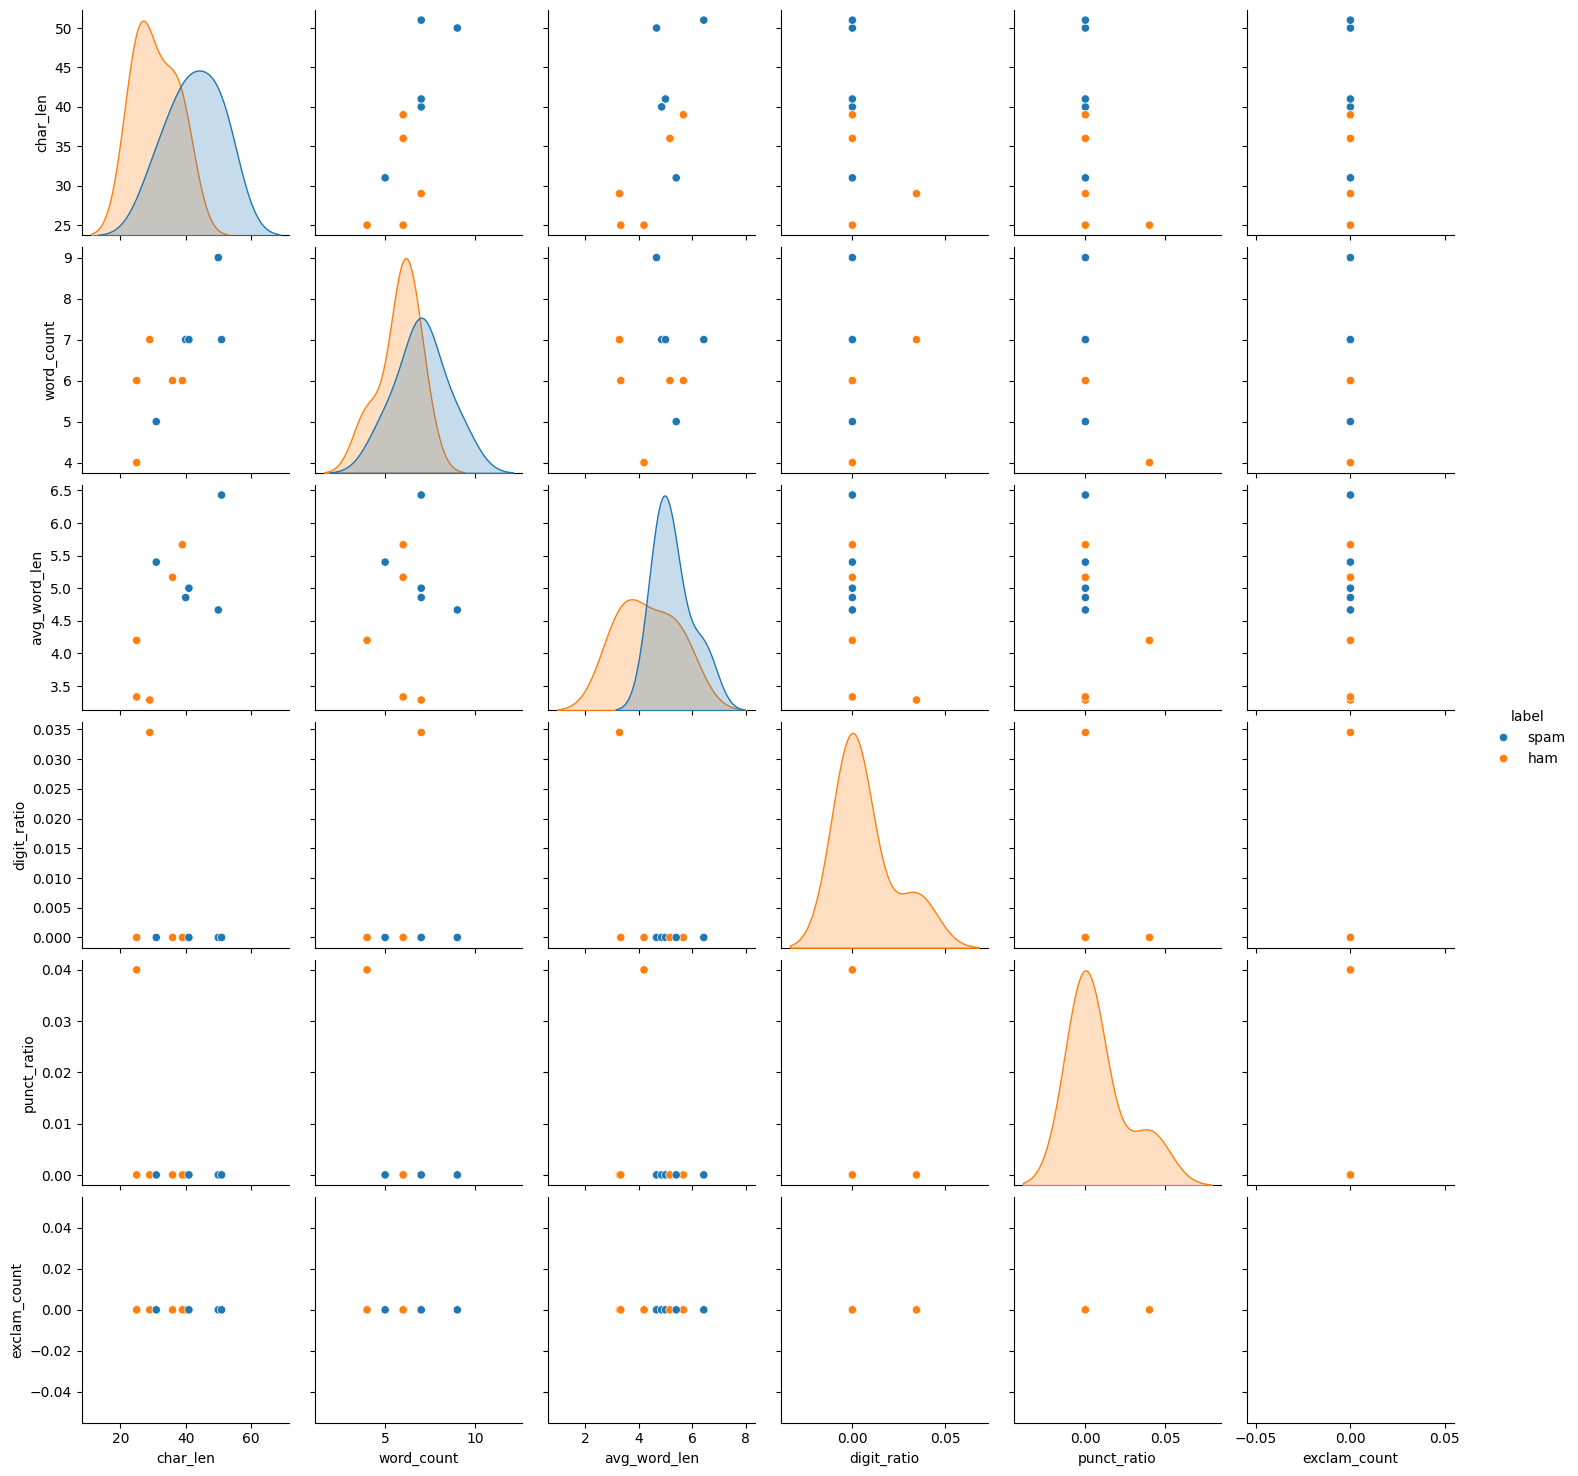

In [46]:
plot_cols = ["char_len", "word_count", "avg_word_len", "digit_ratio", "punct_ratio", "exclam_count"]
pair_df = df_feat[plot_cols + ["label"]].copy()

sns.pairplot(pair_df, hue="label", diag_kind="kde")
plt.show()


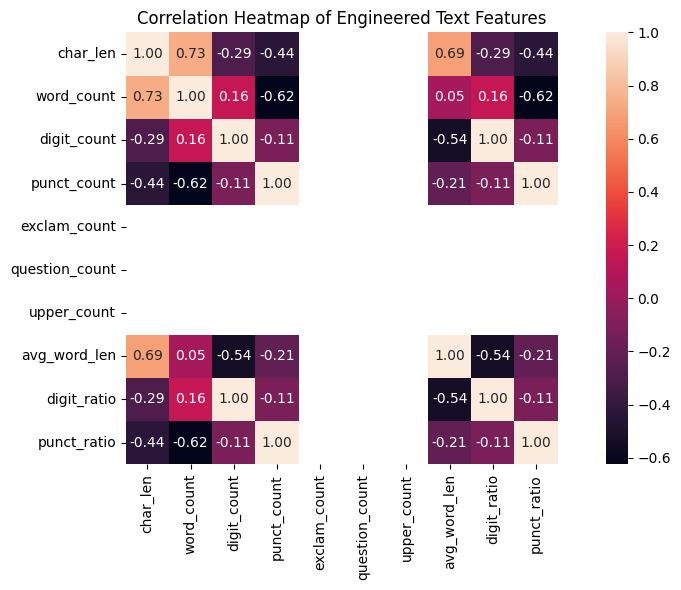

In [47]:
corr_cols = ["char_len","word_count","digit_count","punct_count","exclam_count","question_count","upper_count","avg_word_len","digit_ratio","punct_ratio"]
corr = df_feat[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap of Engineered Text Features")
plt.tight_layout()
plt.show()


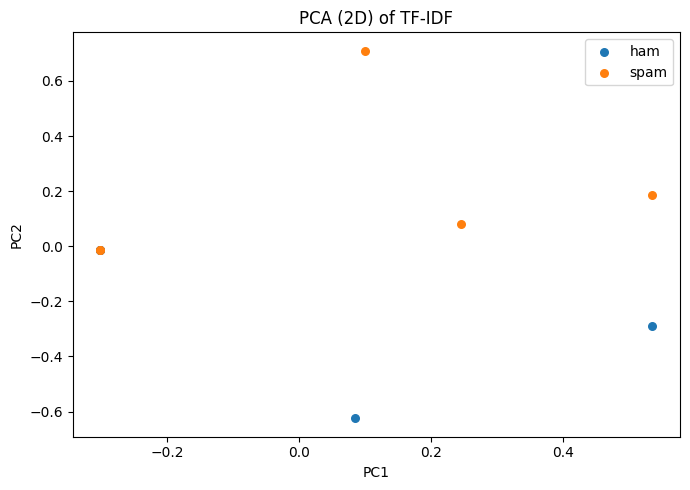

In [48]:
vect2 = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)
X_vec = vect2.fit_transform(df["text"]).toarray()

pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca2.fit_transform(X_vec)

plt.figure(figsize=(7, 5))
for lab in np.unique(y):
    idx = (y == lab)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=le.classes_[lab], s=30)
plt.title("PCA (2D) of TF-IDF")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


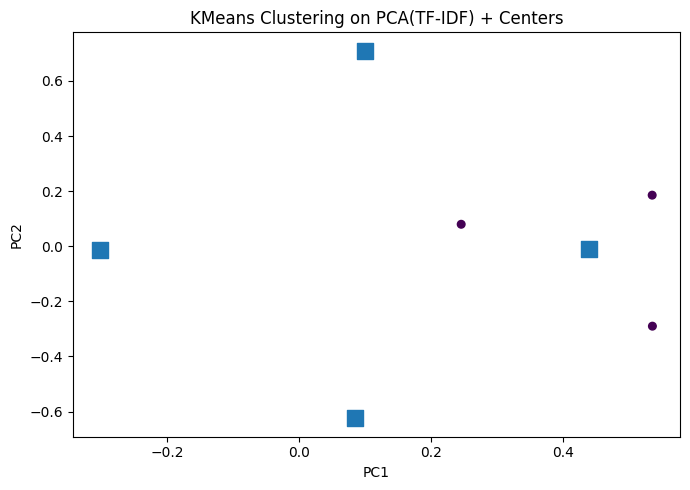

In [49]:
k = min(4, len(df))
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_pca)

centers = kmeans.cluster_centers_

plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, s=30)
plt.scatter(centers[:, 0], centers[:, 1], s=120, marker="s")
plt.title("KMeans Clustering on PCA(TF-IDF) + Centers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


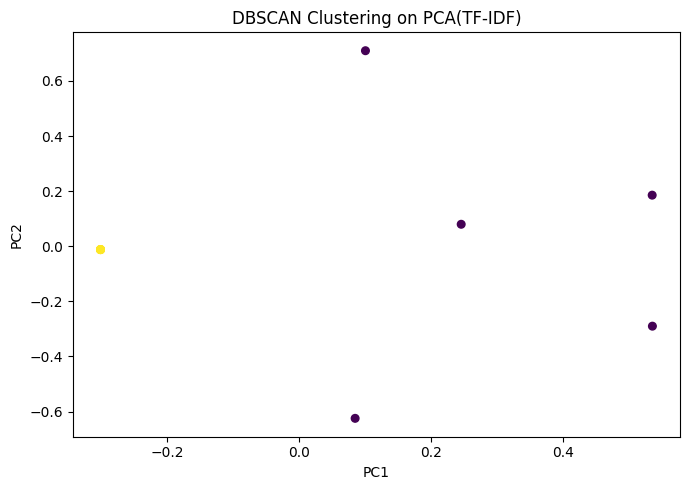

(array([-1,  0]), array([5, 5]))

In [50]:
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

db = DBSCAN(eps=0.8, min_samples=2)
db_labels = db.fit_predict(X_pca_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, s=30)
plt.title("DBSCAN Clustering on PCA(TF-IDF)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

np.unique(db_labels, return_counts=True)


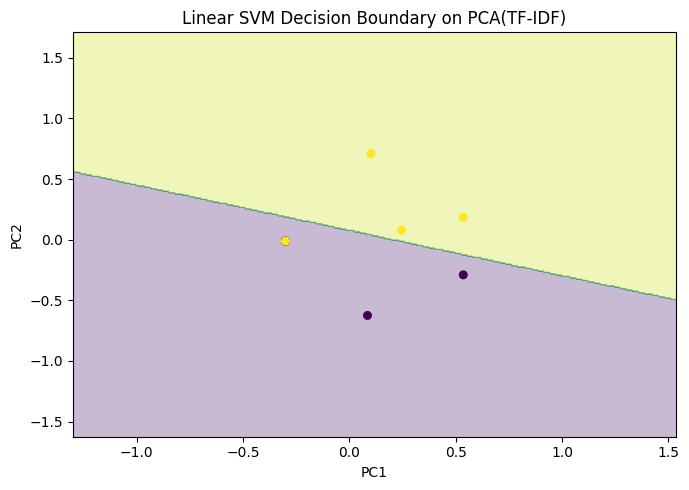

In [51]:
svm2d = SVC(kernel="linear", random_state=RANDOM_STATE)
svm2d.fit(X_pca, y)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = svm2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=30)
plt.title("Linear SVM Decision Boundary on PCA(TF-IDF)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


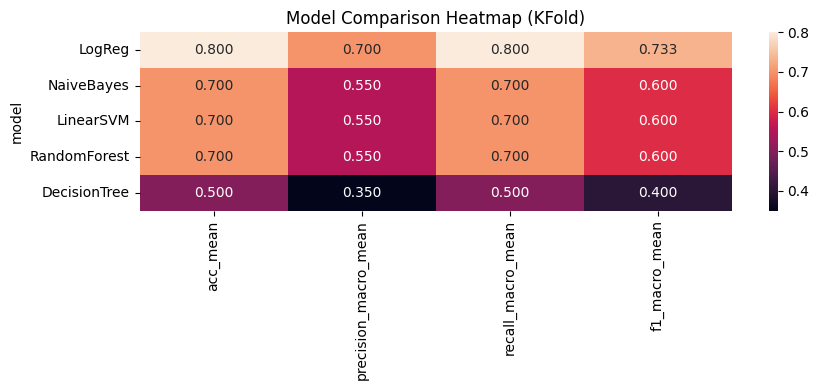

In [52]:
final_table = pd.read_csv("results/model_comparison.csv")

metrics_cols = ["acc_mean","precision_macro_mean","recall_macro_mean","f1_macro_mean"]
heat = final_table[["model","cv_type"] + metrics_cols].copy()
heat = heat.sort_values(["cv_type","f1_macro_mean"], ascending=[True, False])

cv_choice = heat["cv_type"].iloc[0]
heat = heat[heat["cv_type"] == cv_choice].set_index("model")[metrics_cols]

plt.figure(figsize=(9, 4))
sns.heatmap(heat, annot=True, fmt=".3f")
plt.title(f"Model Comparison Heatmap ({cv_choice})")
plt.tight_layout()
plt.show()
